<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [303]:
%%capture
pip install pyswarms

In [304]:
!pip install numpy==1.26

In [305]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [306]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [307]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [308]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [309]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [310]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [311]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [312]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [313]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [314]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [315]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [316]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [343]:
# Defina o dicionário de tipos de dados
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario02.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario03.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario04.csv.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/cenario04.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912


In [344]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [345]:
# Define a função objetivo
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [346]:
# Parâmetros do PSO
num_particles = 50
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

print("")
print("Melhores valores para λ, β, θ :", best_position)

2023-10-03 01:34:54,492 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-.0834
2023-10-03 01:34:54,666 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.0834456299265457, best pos: [148.49617376   1.0019476    0.78338391]



Melhores valores para λ, β, θ : [148.49617376   1.0019476    0.78338391]


In [353]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print(f'lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 148.49617376458846
beta: 1.0019476038793045
theta: 0.7833839096864202


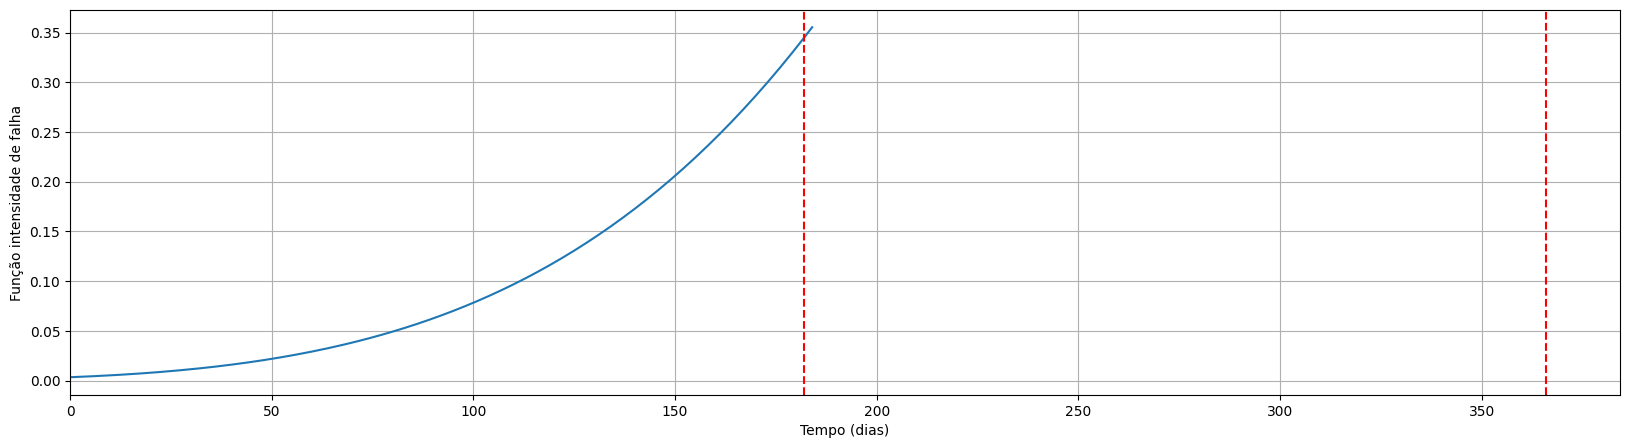

Fator ajuste:  [0.5431425716266389, 0.5431425716266389, 0.5431425716266389, 0.5431425716266389, 0.5431425716266389, 0.32408770659695707, 0.32408770659695707, 0.5431425716266389, 0.32408770659695707, 0.5431425716266389, 0.32408770659695707, 0.5431425716266389, 0.5431425716266389, 0.5431425716266389]


In [355]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [323]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [324]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-03 01:06:03,746 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/100, best_cost=2.19e+3<ipython-input-323-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in scalar divide
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  10%|█         |10/100, best_cost=2.02e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 12, 176, 316, 404, 515]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.10317972709354517, 0.15070586378605966]
Media de falhas:  [0, 0.009205930642114975, 1.9667682137351012, 5.88833781878113, 9.396088449987191, 15.313168691785545, 20.782304167546435]
Custo =  2189.3826039175233


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 21, 59, 108, 196, 328, 338, 553, 575, 645]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.10317972709354517, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.028184781962484366, 0.2180093850387701

pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=2.02e+3

Media de falhas:  [0, 0.020708882614775343, 0.22583707420407184, 0.7158326985386004, 1.068894216548882, 4.4030567684548805, 6.423891583206759, 10.735425421965832, 14.391618296577214, 17.63824956793747, 21.936001290407905, 26.366371213635468, 27.85654513520199, 20.53961494750197]
Custo =  3411.7784098841344


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 24, 275, 331, 432, 455, 496, 553, 614, 678, 699]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0368101650373982, 4.793910732854578, 6.756485230951301, 11.030248522695377, 12.200911641087412, 14.562022617520803, 17.832638199712726, 22.14512043338261, 26.66375394042927, 28.3206687919

pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 9, 64, 115, 193, 259, 301, 430, 472, 496, 606, 642, 678, 695]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.005179127472904084, 0.25893061827227926, 0.7987849545958512, 2.271494499099328, 4.0890664540241195, 5.446629645622108, 11.200208751836792, 13.494791128828759, 14.900160429510438, 21.914191860602777, 24.632261725853486, 27.358928285231055, 28.626066714648278, 21.225882910336914]
Custo =  3844.148066028991


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 87, 113, 177

pyswarms.single.global_best:  65%|██████▌   |65/100, best_cost=2.02e+3

Custo =  3422.099485758902


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 7, 178, 431, 458, 492, 596, 612, 678, 695]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0031334707542723717, 2.0161482816818412, 11.253987638485697, 12.56151493678153, 14.516652551852644, 20.750673433390606, 21.918987174759657, 26.81770198300114, 28.154679320718724, 20.75449551640736]
Custo =  3641.7013380561616


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 6, 85, 178, 206, 264, 431, 496, 594, 613, 654, 676, 695]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262

pyswarms.single.global_best:  83%|████████▎ |83/100, best_cost=2.02e+3

[0, 0.009205930642114975, 0.5589140535953917, 4.529898450192242, 10.797257998708893, 13.028116662828337, 19.769544393465118, 21.449344381994983, 27.016217317947397, 21.047264467698852]
Custo =  2599.158629404548


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 51, 117, 121, 360, 394, 431, 475, 569, 586, 610, 677]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.10317972709354517, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655]
Media de falhas:  [0, 0.006393626648431273, 0.16392261705763456, 0.8275225090809647, 0.8821317931784465, 7.661716184772058, 9.136136278148241, 10.80325219653321, 13.096663450388416, 19.054576843809386, 20.241573754368883, 21.802092908097976, 26.76

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=2.02e+3
2023-10-03 01:06:04,918 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382761 0.88472387 0.78246431 6.54235645 1.86051049 5.73998208
 4.32437094 2.47795997 2.27466465 5.39448676 0.47877334 2.9656412
 5.15080478 6.58093572 1.3888331  0.81326228 1.8363243  1.34471803
 5.49923662 5.23622264 3.02688945 2.50712631 1.32663923 1.26945739]
2023-10-03 01:06:04,920 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 18, 64, 188, 270, 361, 431, 482, 569, 581, 651, 686]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655]
Media de falhas:  [0, 0.020708882614775343, 0.25711857175345526, 2.14725143102645, 4.439596254455909, 7.77984488269419, 10.83094579061568, 13.378762967643336, 18.92771302886955, 19.761768227757635, 24.48065980634527, 27.165371163421437, 21.245332415418368]
Custo =  3424.4581240750217


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 16, 59, 76, 113, 149, 363, 431, 480, 567, 576, 607, 633, 683]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:04,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [2.99267134 0.88752123 0.78003489 6.54287755 1.86057704 5.72423474
 4.32433322 2.45259273 2.27432697 5.3961299  0.48093732 2.95460579
 5.15075644 6.58011951 1.37822605 0.80375393 1.91657296 1.33932741
 5.51736841 5.22848515 3.05807788 2.50704844 1.32630564 1.26851601]
2023-10-03 01:06:04,940 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 13, 44, 84, 113, 123, 176, 181, 398, 431, 486, 531, 568, 594, 616, 674, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.10317972709354517, 0.10317972709354517, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.01080372306762186, 0.1214895462252353, 0.4252503578914427, 0.7735024570620191, 0.9165128712802882, 1.8421634374921227, 1.9445008826198185, 9.206074822422762, 10.77844537647953, 13.540118584352284, 16.31150776032086, 18.77238053167405, 20.599565605942054, 22.046295140420156, 26.348174674235022, 27.8361761947

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:04,956 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [2.99778223 0.88560234 0.77930444 6.54297545 1.86049878 5.72389262
 4.32398877 2.4559755  2.27368569 5.39458585 0.47952027 2.95522932
 5.14925702 6.57633248 1.37474055 0.80313833 1.93580727 1.33698831
 5.49362866 5.22683021 3.05366554 2.50696142 1.32729056 1.26708247]
2023-10-03 01:06:04,957 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 47, 113, 175, 305, 419, 431, 492, 533, 568, 618, 671, 694]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.006393626648431273, 0.1391050725741643, 0.7724861661757753, 1.8648362804140302, 5.547221649847757, 10.144528840020147, 10.761230353146644, 13.847513114779114, 16.391805645908157, 18.723647901134548, 22.31396374666215, 26.041747788277526, 27.840988127462627, 20.524057939762606]
Custo =  4119.245831988901


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:04,967 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00367173 0.88382408 0.77946314 6.54294007 1.86043056 5.72381038
 4.32369638 2.46470256 2.27327892 5.39318813 0.47820599 2.95682836
 5.14793708 6.57348131 1.37416117 0.80375732 1.92363475 1.33539084
 5.47340612 5.22720771 3.04196751 2.50692658 1.32805596 1.26599674]
2023-10-03 01:06:04,968 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 7, 48, 115, 173, 184, 309, 401, 431, 499, 533, 566, 615, 641, 668, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0031334707542723717, 0.14562412956568954, 0.8005465789431534, 1.8216387129747018, 2.0472154828909965, 5.537371694732386, 9.33058710660626, 10.841559368740594, 14.312355255002458, 16.435821626649172, 18.63020819454307, 22.133761449075898, 23.90928735047789, 25.935709655476792, 28.01207673731551, 20.528525341738376]
Custo =  5456.34905899

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 3, 45, 60, 149, 170, 192, 270, 310, 406, 431, 467, 506, 529, 565, 585, 610, 666, 697]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0005757945720706592, 0.12868155778543136, 0.22037444557092264, 1.3717228332493445, 1.7781325403662207, 2.261117704490085, 4.272763280377436, 5.610910152270376, 9.424129801246357, 10.690398744770192, 12.548463496784574, 14.845938383799204, 16.1


2023-10-03 01:06:04,991 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00897866 0.8824622  0.78009453 6.542734   1.860381   5.72516371
 4.32357175 2.47526212 2.27304439 5.39212151 0.47704068 2.96006833
 5.14683984 6.572611   1.37419555 0.80490549 1.894564   1.33536237
 5.45551687 5.23010436 3.02992167 2.50690556 1.32856157 1.26528246]
2023-10-03 01:06:04,992 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,001 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.01357612 0.88178391 0.78111238 6.54244283 1.86036304 5.72776996
 4.32352013 2.48552564 2.27329299 5.39122113 0.47631081 2.96305833
 5.14697115 6.57192022 1.37735174 0.80786029 1.85098035 1.33725209
 5.45000611 5.23303144 3.01835737 2.50692185 1.32882679 1.26514923]
2023-10-03 01:0



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 37, 104, 135, 169, 203, 276, 303, 394, 431, 525, 562, 598, 604, 664, 699]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.08746793175294582, 0.6771873414056642, 1.1283393510851554, 1.6997941042512554, 2.4681432712504234, 4.414555052649846, 5.3139505277213255, 8.830552252266259, 10.679320820033496, 16.137805448211, 18.571872599806152, 21.098690533701106, 21.48973188885614, 25.645680469218867, 28.38241544493519, 20.648077428507108]
Custo =  5292.66879668

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.01732037 0.88171033 0.78229892 6.54215853 1.86038862 5.7327784
 4.32363379 2.49428539 2.27379371 5.39123402 0.47618542 2.9663598
 5.14799464 6.57139699 1.38230934 0.81213663 1.80757193 1.33939442
 5.45209184 5.23656533 3.00947525 2.50697286 1.32860044 1.26519937]
2023-10-03 01:06:05,016 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 64, 123, 167, 283, 361, 431, 462, 521, 557, 664, 700]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.2616248117408689, 0.9454621947484252, 1.6886638764929023, 4.888761429401641, 7.669348577182436, 10.720449485103927, 12.229590959165614, 15.74486636778548, 17.973446520944293, 25.9034070476311, 28.575788631996193, 20.757627126556912]
Custo =  3349.8472764028293


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.01689629 0.882492   0.78338873 6.5419616  1.86043402 5.73932958
 4.32393059 2.49966217 2.27441396 5.39131376 0.47623747 2.9691426
 5.14967663 6.57319347 1.3870548  0.81623992 1.77420504 1.34183234
 5.45479776 5.23964504 3.00521497 2.50702206 1.32837015 1.26608102]
2023-10-03 01:06:05,033 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 84, 167, 288, 368, 391, 431, 479, 516, 553, 664, 701]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.45062451175368756, 1.7425328987942368, 4.989788943600093, 7.895205584429645, 8.846217821497344, 10.64315980780063, 13.157304689978327, 15.385856741158614, 17.779715168226062, 25.98081824839428, 28.72979130050045, 20.82769233183106]
Custo =  3433.9318825557357


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,042 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.01609255 0.88351986 0.7842777  6.54189026 1.86048282 5.74537592
 4.32431119 2.50030081 2.27504594 5.3917616  0.47648797 2.97145877
 5.15120538 6.57622967 1.39142131 0.81966035 1.75118495 1.34406928
 5.45909026 5.24163859 3.00309272 2.50707815 1.3279044  1.26691656]
2023-10-03 01:06:05,043 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 85, 167, 292, 375, 419, 431, 513, 550, 665, 702]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.4614146298083783, 1.7425438672810722, 5.129036729473201, 8.19524802706152, 10.10685599345809, 10.660905801521395, 14.919472583678363, 17.299928023054186, 25.784234844804505, 28.537214285054173, 20.55106387902248]
Custo =  3343.7247553851244


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.01398538 0.88471592 0.78492854 6.54192689 1.86053495 5.75074715
 4.32467062 2.49725735 2.27559959 5.39256434 0.47715817 2.97227862
 5.152509   6.57995019 1.39487196 0.82111981 1.75432512 1.34611696
 5.47111718 5.24182937 3.00259116 2.50713152 1.32731025 1.26776247]
2023-10-03 01:06:05,058 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 69, 98, 168, 295, 380, 431, 511, 547, 597, 668, 702]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.3040883671078812, 0.6024141020995843, 1.7006327565710382, 5.172038354938518, 8.35059689377946, 10.61670758517285, 14.761205504414749, 17.066335381702658, 20.52987220949326, 25.443715271954318, 27.978022586353433, 19.99187218032174]
Custo =  3494.715830160446


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,075 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.01062888 0.88579336 0.7852808  6.54198087 1.86057617 5.75522904
 4.32495227 2.4941726  2.27607493 5.39349858 0.47776174 2.97154293
 5.15342977 6.58337141 1.39763578 0.82163892 1.76250358 1.34783742
 5.48950974 5.24046946 3.00621785 2.50717812 1.32659975 1.26860411]
2023-10-03 01:06:05,076 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 124, 169, 296, 313, 382, 406, 431, 477, 511, 546, 589, 670, 701]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.9817699861028188, 1.792996066905992, 5.4163324181693415, 5.9801654255212995, 8.624539242809702, 9.654823550747098, 10.794616867026255, 13.19813990464278, 15.231284448679709, 17.355705076520792, 20.30996616733147, 25.897367975521764, 28.208844856106975, 20.306745887437582]
Custo =  5051.734804590232


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,093 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00741797 0.88673408 0.7852176  6.54208889 1.86060314 5.75904938
 4.3251549  2.48923195 2.27623727 5.39449554 0.47835084 2.96925972
 5.15379064 6.58612784 1.39778208 0.82056661 1.78867714 1.34870882
 5.50610743 5.23832575 3.0116053  2.50721252 1.32596567 1.26954794]
2023-10-03 01:06:05,094 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 135, 170, 296, 382, 411, 431, 472, 511, 547, 578, 672, 700]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.41901991846626313, 1.1398364604747024, 1.7892395285214877, 5.391230655081498, 8.621983703023155, 9.876156580026079, 10.792445746365589, 12.81454910605737, 15.135570857361463, 17.440700734649372, 19.55054494938448, 26.000624856878893, 28.089119381562952, 20.27095787612367]
Custo =  4664.766492008612


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00390444 0.88701796 0.78463391 6.54222242 1.86062581 5.76149899
 4.32520729 2.48324785 2.27634232 5.39539028 0.47893136 2.96692103
 5.15376098 6.5884095  1.3975543  0.81783506 1.81656878 1.34871581
 5.51943178 5.23628785 3.01832749 2.5072216  1.32547849 1.27039731]
2023-10-03 01:06:05,112 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 144, 172, 295, 378, 431, 507, 514, 549, 636, 673, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3239051282623775, 1.8667067417603493, 5.3891193800300075, 8.482302596449939, 10.832558462565473, 14.750448814580151, 15.182345685253486, 17.433891390978502, 23.68666127737753, 26.32345418404588, 28.395703082192043, 20.74507458046939]
Custo =  3995.8673931916887


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,129 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00390444 0.88701796 0.78463391 6.54222242 1.86062581 5.76149899
 4.32520729 2.48324785 2.27634232 5.39539028 0.47893136 2.96692103
 5.15376098 6.5884095  1.3975543  0.81783506 1.81656878 1.34871581
 5.51943178 5.23628785 3.01832749 2.5072216  1.32547849 1.27039731]
2023-10-03 01:06:05,135 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 0, 173, 293, 371, 431, 461, 503, 516, 553, 602, 674, 697]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.9106527061566612, 5.20578802946593, 8.070866636812255, 10.712824116130303, 12.171370764324658, 14.623177675082713, 15.382121562418558, 17.775979989486007, 21.202620744791503, 26.229245276594728, 28.036374860265674, 20.469341898855703]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,150 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [2.99899802 0.88655478 0.782885   6.54246984 1.86062042 5.75594558
 4.32523355 2.47285502 2.27633188 5.39640369 0.47968392 2.96416216
 5.15310545 6.58822112 1.39525061 0.812781   1.86431441 1.34606456
 5.53545114 5.2338701  3.03255483 2.50720904 1.32545205 1.27106582]
2023-10-03 01:06:05,151 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 1, 174, 289, 323, 368, 390, 431, 502, 518, 555, 603, 674, 696]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 6.401452579813218e-05, 1.9318578486013858, 5.0661793192181355, 6.204924976681792, 7.909389635439898, 8.817650639872097, 10.657689795701838, 14.676475330980132, 15.663188669410404, 18.065982399421884, 21.431223026183805, 26.391195348258748, 28.11835168087805, 20.634800285300916]
Custo =  8294.720085097824


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 3, 68, 175, 285, 319, 364, 431, 463, 501, 520, 557, 603, 649, 673, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0005757945720706592, 0.29427896037854784, 1.8582134795813992, 4.9570011080531655, 6.081014283352605, 7.765981348797028, 10.999172663591414, 12.559036484519245, 14.776824491944769, 15.831285769968629, 18.24301478525434, 21.473280433203918, 24.613471811940165, 26.432099448771652, 28.335636227965036, 20.852084832387902]
Custo =  6153.897


2023-10-03 01:06:05,165 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [2.99812706 0.88587461 0.78202902 6.54253285 1.86058227 5.75122143
 4.32504247 2.47093294 2.27596074 5.39622785 0.47985905 2.96371458
 5.1522715  6.58539365 1.39194819 0.81059154 1.87294075 1.34439985
 5.53248086 5.23344129 3.03732215 2.50718981 1.32561477 1.27070387]
2023-10-03 01:06:05,167 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [2.99825502 0.88497616 0.78130806 6.54254443 1.86053831 5.74644408
 4.3247585  2.46933838 2.27540478 5.39587679 0.47991769 2.96369344
 5.15123562 6.58241517 1.38876852 0.80886035 1.87173467 1.34294836
 5.52466812 5.23385393 3.04042965 2.50715874 1.32605308 1.27010789]
2023-10-03 01:0



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 4, 76, 112, 174, 280, 362, 410, 431, 500, 522, 557, 603, 672, 695]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.001023478360461457, 0.3673306665509872, 0.7633926399417733, 1.7616755807708744, 4.707933084387827, 7.625383774089615, 9.65543024501196, 10.616598423531618, 14.513380415499531, 15.873213707989756, 18.158568669710107, 21.388834317659686, 26.200291755810305, 28.00216184519666, 20.601978040885292]
Custo =  5111.4519231048525


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 32, 174, 276, 431, 500, 523, 557, 602, 637, 670, 695]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.001023478360461457, 0.06482046525723424, 1.8723547158738734, 4.68141102563339, 10.850486392478487, 14.376722786220899, 15.799833012955816, 18.02182995978938, 21.179003736904114, 23.53994595934135, 26.014213398460516, 27.970238271847904, 20.570054467536536]
Custo =  4596.761788956248


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [2.99941357 0.88413666 0.78082897 6.5425326  1.86049098 5.74122351
 4.32446334 2.47031897 2.27487385 5.39536668 0.47989784 2.96417072
 5.15024172 6.57950162 1.38590797 0.80731212 1.86585687 1.34194576
 5.51744876 5.23448344 3.04194434 2.50712894 1.32645751 1.26947054]
2023-10-03 01:06:05,208 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 40, 172, 273, 405, 431, 451, 501, 524, 557, 600, 669, 695]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.001023478360461457, 0.10143872566770075, 1.8183255233155649, 4.5689981352028415, 9.586171300900336, 10.770398173277064, 11.782253227497964, 14.66619588683574, 16.0183461849526, 18.176871124985087, 21.188243649180293, 25.977286171898797, 28.010236661942397, 20.610052857631032]
Custo =  4860.328172989622


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,221 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00078624 0.88342149 0.78049901 6.54251489 1.86044937 5.73645369
 4.3241814  2.47160845 2.27435489 5.39475768 0.47977398 2.96465088
 5.14951551 6.57728034 1.38374242 0.80722458 1.85888174 1.34135567
 5.50913493 5.23526332 3.04231291 2.50710183 1.32686319 1.26889381]
2023-10-03 01:06:05,226 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 3, 45, 99, 171, 272, 310, 431, 502, 523, 557, 573, 668, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0005757945720706592, 0.12868155778543136, 0.5931876932617189, 1.7858553154258114, 4.4137585286213445, 5.626188050467061, 10.625326704132942, 14.644112239411236, 15.945867617072619, 18.167864563906182, 19.260835424987942, 25.734153713779847, 27.810520795618565, 20.32696940004143]
Custo =  5508.274688144354


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0029099  0.8828009  0.78064455 6.54248765 1.86042316 5.73265571
 4.32398127 2.47299299 2.27389672 5.39417364 0.47959971 2.96509291
 5.1489844  6.57534773 1.38306263 0.80849495 1.84824357 1.34179862
 5.50129536 5.23598743 3.04115238 2.50708194 1.32720604 1.26845171]
2023-10-03 01:06:05,243 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 1, 47, 146, 170, 272, 310, 431, 457, 504, 522, 556, 579, 667, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 6.401452579813218e-05, 0.14086870116611194, 1.2994045063728228, 1.7597663804226724, 4.519534878687889, 5.731964400533605, 10.731103054199487, 11.988545612336, 14.724514989493606, 15.783156738180763, 18.00104829149659, 19.579680560318018, 25.593922702996664, 27.743154277578043, 20.25960288200091]
Custo =  8882.506627337778


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00507655 0.88277638 0.78099165 6.54244855 1.86041067 5.7310227
 4.32387858 2.4751577  2.2735844  5.39369943 0.47928883 2.96555799
 5.1489151  6.57395991 1.38413983 0.81057803 1.83779334 1.3430159
 5.49418634 5.23667263 3.03759295 2.50706932 1.32738022 1.26809026]
2023-10-03 01:06:05,259 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 42, 108, 142, 169, 274, 327, 431, 506, 521, 555, 584, 666, 697]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.11269762025317419, 0.7297293640898539, 1.2474834099823902, 1.7575085159229131, 4.605852728429609, 6.359056469119303, 10.734599472690931, 14.998922192633156, 15.930254662633628, 18.144040818390913, 20.14208111629503, 25.759293657461175, 28.0573437237392, 20.49031076232923]
Custo =  4235.579315147826


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00689146 0.88329765 0.78132354 6.54239404 1.86040374 5.73111282
 4.32379904 2.47726758 2.273595   5.39333694 0.4788786  2.96597746
 5.14905654 6.57430428 1.38615094 0.81263214 1.82809124 1.34462194
 5.48924412 5.23725812 3.03391689 2.50706217 1.32732844 1.2681137 ]
2023-10-03 01:06:05,271 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 36, 80, 97, 138, 169, 276, 324, 361, 431, 507, 519, 554, 587, 665, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.08280503258439238, 0.40012140249732486, 0.5830335642510653, 1.1216056252628142, 1.6467828939862774, 4.563030009726496, 6.145930868893982, 7.532511571527797, 10.583612479449286, 14.501502831463965, 15.245722684105338, 17.518399206208475, 19.796461702519675, 25.145112853448822, 27.592058264835945, 19.94142976311329]
Custo =  5790.2740


2023-10-03 01:06:05,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00805144 0.88401936 0.7816524  6.5423366  1.8604057  5.73359154
 4.32382057 2.47928652 2.27373246 5.39333592 0.47850669 2.96634963
 5.14946394 6.57592455 1.38876195 0.81463933 1.82131448 1.34609305
 5.48598985 5.23764577 3.02877436 2.50706065 1.32714005 1.26826363]
2023-10-03 01:06:05,295 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 89, 108, 136, 169, 278, 364, 404, 431, 466, 509, 518, 553, 588, 656, 666, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.5058513488159236, 0.7356120155372314, 1.1512792524054465, 1.7633505326057537, 4.7480107430711325, 7.811081663535502, 9.491047011311435, 10.719618348206968, 12.523838611345917, 15.06272538724345, 15.564266318787665, 17.83271668600427, 20.249080037200837, 24.876020362021293, 25.59311157647382, 28.23282


2023-10-03 01:06:05,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0088803  0.88478102 0.7820591  6.54228562 1.86042633 5.73674069
 4.32399068 2.48107404 2.27410336 5.39355978 0.47820842 2.96666114
 5.15005048 6.57846388 1.39112972 0.81612768 1.81623867 1.34735901
 5.48373375 5.23790896 3.02404857 2.50706998 1.32693475 1.26850462]
2023-10-03 01:06:05,316 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 78, 116, 136, 169, 281, 312, 367, 431, 509, 517, 553, 586, 666, 699]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.3885639838620536, 0.8430836113239025, 1.1201881883198013, 1.6763062567359945, 4.764542713916006, 5.770014547271453, 7.822788815089651, 10.629472823938197, 14.660411932726756, 15.156450390827693, 17.487661784276682, 19.761739750109314, 25.24907287566958, 27.699591555844904, 19.96525353941682]
Custo =  5343.601870743618


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,331 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00913538 0.88545185 0.78247256 6.54225897 1.86045415 5.74026909
 4.3242111  2.48239049 2.27447776 5.39393903 0.47805354 2.96679143
 5.15079636 6.58080256 1.3929898  0.81690789 1.81391868 1.34824556
 5.48497485 5.23781734 3.02014174 2.50707861 1.32673582 1.2688461 ]
2023-10-03 01:06:05,332 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 74, 138, 170, 284, 327, 368, 412, 431, 474, 509, 517, 553, 582, 657, 667, 699]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.34974291339719676, 1.1901443384892647, 1.7893595804875992, 4.961056088368186, 6.402624608624141, 7.962887498343328, 10.042905477955504, 10.914226541258552, 13.271376000703125, 15.353871292398061, 15.82385248731542, 18.15506388076441, 20.146101054102665, 25.234084021968705, 25.95225806432532, 28.459272


2023-10-03 01:06:05,344 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00813035 0.88593711 0.78284343 6.54224957 1.86048849 5.74337317
 4.32443182 2.48255776 2.27484554 5.39428385 0.47811772 2.96673299
 5.1514678  6.58291895 1.3934802  0.81668459 1.81568656 1.34870898
 5.48707775 5.23729557 3.0167996  2.50709829 1.32655186 1.26926206]
2023-10-03 01:06:05,345 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,357 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00717575 0.88605822 0.78307116 6.54227082 1.86052329 5.74563792
 4.32462784 2.48270123 2.27513128 5.39462821 0.4782026  2.96654935
 5.15190215 6.58465581 1.39296379 0.81616985 1.8188101  1.34898515
 5.48991687 5.23671838 3.0147247  2.50711661 1.32639434 1.26965883]
2023-10-03 01:0



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 141, 170, 287, 311, 369, 394, 431, 509, 517, 553, 579, 669, 699]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.2693312233752192, 1.8227416751958976, 5.1002899847371115, 5.883604888943926, 8.053162017433522, 9.0927671740127, 10.759883092397668, 15.209697532193147, 15.705735990294084, 18.036947383743072, 19.81704269751315, 25.979447057391, 28.211199333410732, 20.47686131698265]
Custo =  5254.878651984352


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,368 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.005904   0.8858524  0.78312488 6.54230124 1.86055422 5.74755515
 4.32478738 2.48229692 2.27534451 5.39493682 0.47828575 2.9663157
 5.15204251 6.58586449 1.39221182 0.81496218 1.82679359 1.34841332
 5.49248003 5.23612469 3.01374607 2.50713423 1.3262535  1.27000496]
2023-10-03 01:06:05,369 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 104, 145, 171, 289, 324, 369, 431, 475, 508, 518, 553, 576, 600, 649, 670, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.6906748490305396, 1.3191598221602079, 1.7939211719750223, 5.121263104106538, 6.295733363019893, 8.005072401493367, 11.014652340405986, 13.193130900028674, 15.156403497794646, 15.744011554686317, 18.012461921902926, 19.582762866763467, 21.117292671210848, 24.455732376080597, 26.0430155171923, 28.125446

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.005904   0.8858524  0.78312488 6.54230124 1.86055422 5.74755515
 4.32478738 2.48229692 2.27534451 5.39493682 0.47828575 2.9663157
 5.15204251 6.58586449 1.39221182 0.81496218 1.82679359 1.34841332
 5.49248003 5.23612469 3.01374607 2.50713423 1.3262535  1.27000496]




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 0, 76, 148, 172, 289, 311, 369, 431, 506, 519, 553, 573, 601, 645, 672, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.36889818251161727, 1.3264077709927147, 1.7698255203574051, 5.075641421418677, 5.795640425730819, 7.965197554220416, 10.689696490605037, 14.551253734744616, 15.356750951657151, 17.562326300144868, 18.923980370090693, 20.712309088182074, 23.70083125316483, 25.73960220740918, 27.781470976169462, 20.1308

2023-10-03 01:06:05,379 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.005904   0.8858524  0.78312488 6.54230124 1.86055422 5.74755515
 4.32478738 2.48229692 2.27534451 5.39493682 0.47828575 2.9663157
 5.15204251 6.58586449 1.39221182 0.81496218 1.82679359 1.34841332
 5.49248003 5.23612469 3.01374607 2.50713423 1.3262535  1.27000496]
2023-10-03 01:06:05,390 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 0, 60, 172, 289, 369, 402, 431, 505, 519, 554, 571, 601, 672, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.22995156635275565, 1.8001537542690114, 4.855133671746982, 7.769216080667138, 9.15832924180085, 10.475322232511632, 14.473966065664762, 15.340626652940522, 17.613303175043658, 18.769510520470224, 20.682904772245802, 25.627500699928554, 27.669369468688835, 20.01874096696618]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.005904   0.8858524  0.78312488 6.54230124 1.86055422 5.74755515
 4.32478738 2.48229692 2.27534451 5.39493682 0.47828575 2.9663157
 5.15204251 6.58586449 1.39221182 0.81496218 1.82679359 1.34841332
 5.49248003 5.23612469 3.01374607 2.50713423 1.3262535  1.27000496]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 0, 172, 287, 304, 368, 431, 504, 519, 555, 570, 601, 646, 672, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.8886338916414196, 4.9966428751055565, 5.543901684977205, 7.913855701594236, 10.820009148938802, 14.569282719118974, 15.496992682729822, 17.836897880330966, 18.856979485317616, 20.83277289102491, 23.8920847680922, 25.8566610901266, 28.010318257192456, 20.3596897554698]
Custo =  inf


2023-10-03 01:06:05,402 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,411 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00343744 0.88464675 0.7826073  6.54236315 1.86056851 5.74663027
 4.32445812 2.47936361 2.27520364 5.3951572  0.47851751 2.96549791
 5.15113322 6.58367816 1.38777464 0.81343241 1.83858535 1.3456107
 5.49821009 5.23567962 3.02050978 2.50713102 1.32655182 1.26995282]
2023-10-03 01:06:05,412 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 149, 172, 285, 315, 367, 400, 431, 504, 519, 555, 573, 601, 644, 670, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.4174134248088202, 1.8699970583403416, 5.033966025212258, 6.018089426160169, 7.965844081126388, 9.347808539985953, 10.752866816735724, 14.894165928381664, 15.821875891992512, 18.161781089593656, 19.389321531730932, 21.177650249822314, 24.09551020110192, 26.054140884144505, 28.370272658770972, 20.719644157048318]
Custo =  6212.36852

pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 148, 171, 283, 366, 399, 431, 472, 504, 519, 555, 576, 600, 648, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3984565888336495, 1.848230839448862, 4.963527088425476, 7.9488218629814344, 9.327211963333033, 10.776169244880148, 12.905369189841963, 14.795516230747547, 15.629033620538134, 17.96893881813928, 19.405085594895386, 20.939615399342763, 24.20686368302722, 25.79174570211332, 28.18894381519962, 20.538315313476968]
Custo =  6108.07232708

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,421 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00357117 0.88465562 0.78259071 6.54235508 1.8605509  5.74538348
 4.32432907 2.47810777 2.27505768 5.39486742 0.47847272 2.96544097
 5.15098531 6.58239436 1.38748011 0.81360728 1.83322763 1.34513184
 5.49660439 5.23598057 3.02622194 2.50711722 1.32671506 1.26954499]
2023-10-03 01:06:05,422 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,430 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00376722 0.88466808 0.78256324 6.54234801 1.86053082 5.7436591
 4.3242225  2.47694333 2.27485408 5.39451474 0.47848212 2.96543683
 5.15082195 6.58098845 1.38753415 0.8136933  1.82896022 1.34460858
 5.4958181  5.236



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 109, 146, 171, 280, 365, 398, 431, 450, 504, 519, 555, 579, 600, 656, 667, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.7586633853694353, 1.3389905811309117, 1.7967576634464606, 4.807752940497547, 7.848201189663312, 9.223016926575974, 10.7157841206085, 11.626204119356764, 14.748112606756631, 15.627445075698265, 17.96735027329941, 19.613250878787355, 20.95877029218808, 24.799119879118475, 25.632345868159476, 28.19133472

pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 31, 72, 144, 170, 279, 364, 431, 504, 519, 555, 581, 600, 666, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.06140583184863294, 0.3241819354844149, 1.2819312223205812, 1.7310139907133313, 4.728841750183836, 7.760082528892259, 10.689375922970232, 14.438649493150404, 15.366359456761252, 17.706264654362396, 19.492638640752464, 20.711705753567877, 25.279906695437337, 27.783262391366364, 20.13263388964371]
Custo =  5095.899232519887


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,440 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00396123 0.88468199 0.7825364  6.54234324 1.86050984 5.7415706
 4.32414785 2.47604411 2.27462015 5.39419217 0.47855903 2.96546422
 5.1506733  6.57971958 1.38772516 0.81375466 1.82547491 1.34416766
 5.49531745 5.23657654 3.0356467  2.5071014  1.32695491 1.26882218]
2023-10-03 01:06:05,441 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00411726 0.88469709 0.78249073 6.5423424  1.86049106 5.73966001
 4.32410177 2.47576573 2.27442268 5.39396125 0.47868734 2.96554009
 5.15054    6.57887327 1.38821568 0.81373841 1.82327508 1.34385998
 5.49498331 5.236



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 33, 119, 142, 170, 278, 363, 403, 431, 505, 519, 555, 582, 666, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.06958244519144756, 0.8887707822407747, 1.2534472505005785, 1.7586894063661738, 4.722126056542319, 7.744159349810969, 9.419792148047156, 10.692618857761289, 14.691262690914419, 15.557923278190179, 17.897828475791325, 19.754630400787317, 25.501366060039295, 27.875586686616597, 20.224958184893943]
Custo =  4724.960137759472


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 33, 73, 142, 170, 278, 363, 431, 477, 505, 520, 555, 583, 631, 666, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.06958244519144756, 0.33317396431636687, 1.246148559188599, 1.7513907150541943, 4.71482736523034, 7.7368606584989905, 10.706845654192094, 12.990211941459492, 14.653855495962238, 15.583376713705983, 17.860279386516744, 19.787636748724907, 22.966523135692423, 25.437374677117464, 27.94073037304649, 20.290101871323838]
Custo =  5080.79499

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00423023 0.88471851 0.78244961 6.54234224 1.86047696 5.73797456
 4.32409331 2.47616626 2.27431101 5.39381178 0.47881188 2.96561648
 5.15047326 6.57816012 1.38868653 0.81358501 1.82342821 1.34364749
 5.49471944 5.2367491  3.0399809  2.50710545 1.32701564 1.26848243]
2023-10-03 01:06:05,461 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 33, 63, 100, 141, 171, 278, 303, 362, 431, 505, 520, 555, 582, 636, 667, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.06958244519144756, 0.24812769180885452, 0.6174276248407458, 1.1941961325508261, 1.7102712179908122, 4.652370247802293, 5.445543635682802, 7.605141835207588, 10.615729335560342, 14.421080985703828, 15.350602203447572, 17.627504876258335, 19.484306801254327, 23.075361733320154, 25.27270934557857, 27.6994

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00426645 0.88473929 0.78241356 6.54234399 1.86047022 5.7367194
 4.32414984 2.47700454 2.27427454 5.39370347 0.47891276 2.96568554
 5.15047089 6.5781369  1.38911941 0.8133959  1.82478108 1.34358471
 5.49569174 5.23669441 3.0390878  2.50711249 1.32702895 1.26868   ]
2023-10-03 01:06:05,472 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,483 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00427699 0.88475353 0.78238417 6.54234578 1.86046967 5.735821
 4.32422622 2.47780728 2.27425771 5.39366787 0.47898092 2.96574697
 5.15054072 6.57866666 1.38947023 0.81320657 1.82855661 1.34353409
 5.49755884 5.23658



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 32, 73, 141, 171, 280, 362, 431, 455, 505, 520, 554, 581, 639, 669, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.06543029265682052, 0.3332174542127875, 1.2286219354096235, 1.7703476914314589, 4.781342968482546, 7.698793658184334, 10.709381158537088, 11.867036802100106, 14.775130377190575, 15.65617816341115, 17.865858917561575, 19.71940076566462, 23.584969263791074, 25.71926773873375, 27.992335297615924, 20.34170679589327]
Custo =  5155.067223185

pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 0, 30, 142, 172, 282, 321, 362, 431, 505, 520, 554, 578, 600, 640, 670, 697]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.05750906492101931, 1.2431470719058482, 1.8155829804881467, 4.874505975357121, 6.1635768618895, 7.697193069286003, 10.859171903395351, 14.664523553538837, 15.594044771282581, 17.803725525433006, 19.446728280533634, 20.85534023234566, 23.55764708470089, 25.81153445883377, 27.927483579354448, 20.3604506

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,493 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00427699 0.88475353 0.78238417 6.54234578 1.86046967 5.735821
 4.32422622 2.47780728 2.27425771 5.39366787 0.47898092 2.96574697
 5.15054072 6.57866666 1.38947023 0.81320657 1.82855661 1.34353409
 5.49755884 5.23658935 3.03468779 2.50711957 1.32702508 1.26887606]
2023-10-03 01:06:05,494 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00427699 0.88475353 0.78238417 6.54234578 1.86046967 5.735821
 4.32422622 2.47780728 2.27425771 5.39366787 0.47898092 2.96574697
 5.15054072 6.57866666 1.38947023 0.81320657 1.82855661 1.34353409
 5.49755884 5.236589



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 142, 172, 283, 315, 363, 431, 505, 520, 554, 576, 600, 635, 671, 697]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.2873949344857711, 1.8325534723713364, 4.926364245164945, 5.973244458062663, 7.758928006615762, 10.878522317384451, 14.683873967527937, 15.613395185271681, 17.823075939422107, 19.32635679444159, 20.860886598888968, 23.214248769421214, 25.91210182484706, 27.95099783634047, 20.3839648749305]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,513 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00427699 0.88475353 0.78238417 6.54234578 1.86046967 5.735821
 4.32422622 2.47780728 2.27425771 5.39366787 0.47898092 2.96574697
 5.15054072 6.57866666 1.38947023 0.81320657 1.82855661 1.34353409
 5.49755884 5.23658935 3.03468779 2.50711957 1.32702508 1.26887606]
2023-10-03 01:06:05,514 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 0, 73, 94, 143, 172, 284, 310, 363, 419, 431, 505, 520, 554, 575, 600, 630, 671, 697]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.3403567306815011, 0.5440809267656384, 1.1968193638510867, 1.7252742692950997, 4.854100366172007, 5.697558199538687, 7.657444507268837, 10.183673301761486, 10.737723109824792, 14.94047027169815, 15.869991489441894, 18.07967224359232, 19.513

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,524 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00427699 0.88475353 0.78238417 6.54234578 1.86046967 5.735821
 4.32422622 2.47780728 2.27425771 5.39366787 0.47898092 2.96574697
 5.15054072 6.57866666 1.38947023 0.81320657 1.82855661 1.34353409
 5.49755884 5.23658935 3.03468779 2.50711957 1.32702508 1.26887606]
2023-10-03 01:06:05,527 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 60, 144, 172, 284, 312, 364, 431, 505, 520, 554, 574, 600, 670, 697]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.22995156635275565, 1.257540801352916, 1.7447409619145664, 4.8735670587914734, 5.785477661537711, 7.716334311440669, 10.793442882220916, 14.598794532364401, 15.528315750108145, 17.73799650425857, 19.102065456553824, 20.7621568141524, 25.625068188296925, 27.741017308817604, 20.173984347407632]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,538 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00427699 0.88475353 0.78238417 6.54234578 1.86046967 5.735821
 4.32422622 2.47780728 2.27425771 5.39366787 0.47898092 2.96574697
 5.15054072 6.57866666 1.38947023 0.81320657 1.82855661 1.34353409
 5.49755884 5.23658935 3.03468779 2.50711957 1.32702508 1.26887606]
2023-10-03 01:06:05,539 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 0, 144, 172, 283, 328, 364, 403, 431, 470, 505, 520, 555, 574, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.3239051282623775, 1.8355551345021337, 4.929365907295741, 6.438849048449898, 7.801256953539373, 9.52277977040735, 10.795606480121481, 12.923540071576761, 14.989129929884815, 15.87017771610539, 18.14708038891615, 19.444028776373752, 21.10412013397233, 25.893162656690834, 28.16623021557301, 20.51560171

pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 79, 143, 171, 282, 363, 431, 505, 520, 555, 577, 600, 668, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.39858833191683474, 1.278084997717801, 1.7865310841536606, 4.8669327960121604, 7.7611877467777415, 10.731172742470845, 14.53652439261433, 15.466045610358075, 17.742948283168836, 19.24888550365482, 20.720500919177425, 25.43580208596326, 27.785733540978164, 20.13510503925551]
Custo =  4817.289484853078


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,548 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381288 0.88473072 0.78248435 6.54235057 1.86047982 5.73637927
 4.32443771 2.4771601  2.27438235 5.39427861 0.47881104 2.96560781
 5.15070895 6.57973244 1.38903857 0.81338777 1.8322524  1.34419507
 5.49707657 5.23662187 3.036754   2.50711251 1.32670357 1.26927826]
2023-10-03 01:06:05,549 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 72, 143, 171, 281, 303, 363, 419, 431, 505, 520, 555, 580, 600, 667, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.3310981837528112, 1.277779865984714, 1.7862259524205735, 4.831860673554324, 5.532793812915965, 7.732821594105895, 10.135841618992927, 10.689891427056232, 14.688535260209362, 15.618056477953106, 17.894959150763867, 19.61103269727695, 20.89337049765055, 25.535057804114253, 27.961751971505354, 20.3111234697827]
Custo =  5905.44545189433

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0037725  0.88472541 0.78251009 6.54235164 1.86046491 5.73614925
 4.32440963 2.4769209  2.27435327 5.39415962 0.47878903 2.96557656
 5.15063932 6.57890579 1.38882418 0.81344646 1.83105661 1.34435884
 5.49667437 5.2367328  3.03876725 2.50710949 1.32666868 1.26930123]
2023-10-03 01:06:05,559 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 84, 142, 170, 280, 363, 431, 505, 520, 555, 582, 600, 667, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.45062451175368756, 1.2608948174200152, 1.7661369732856105, 4.798483389179454, 7.756805729994462, 10.726790725687565, 14.53214237583105, 15.461663593574794, 17.738566266385558, 19.59536819138155, 20.751075542192343, 25.392762848656044, 27.819457016047146, 20.168828514324492]
Custo =  4762.853587419989


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0037369  0.8847204  0.78252262 6.54235319 1.86045916 5.73650869
 4.32437696 2.47698917 2.27433099 5.39409047 0.47876745 2.96556575
 5.15058992 6.57826309 1.38863166 0.81346781 1.83126997 1.34450886
 5.49699288 5.23675741 3.03783266 2.5071106  1.32662981 1.26934311]
2023-10-03 01:06:05,570 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 89, 107, 142, 170, 280, 363, 431, 504, 520, 555, 582, 600, 667, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.5058513488159236, 0.722370803013988, 1.2293737910699867, 1.7105055208172544, 4.742851936711098, 7.701174277526106, 10.67115927321921, 14.420432843399382, 15.4110101945568, 17.68791286736756, 19.544714792363553, 20.700422143174347, 25.34210944963805, 27.76880361702915, 20.118175115306496]
Custo =  5489.069159650735



2023-10-03 01:06:05,587 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00372246 0.88471634 0.78253    6.54235481 1.86045807 5.7374653
 4.32434732 2.47710624 2.27434552 5.39403042 0.47874831 2.96556541
 5.1505787  6.57796483 1.38850067 0.81347157 1.83297381 1.34465732
 5.49767193 5.23674291 3.03520583 2.50711375 1.32659636 1.26941075]
2023-10-03 01:06:05,590 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00371254 0.88471469 0.78252666 6.54235634 1.8604716  5.73858415
 4.3243238  2.47745315 2.2743898  5.39403543 0.47873438 2.96556807
 5.15060825 6.57800136 1.38841974 0.8134123  1.83496741 1.34479416
 5.49829853 5.23668516 3.03046513 2.50711805 1.32657768 1.269481  ]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 92, 143, 170, 279, 363, 431, 504, 520, 554, 581, 600, 667, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.5405189254975875, 1.280065750540532, 1.7933531684291986, 4.791180927899703, 7.781403299728731, 10.751388295421833, 14.500661865602005, 15.491239216759423, 17.700919970909847, 19.554461819012893, 20.773528931828306, 25.415216238292007, 27.84191040568311, 20.191281903960455]
Custo =  4753.482432447462


2023-10-03 01:06:05,600 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,608 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0037275  0.88471324 0.78252083 6.54235773 1.86048555 5.73960426
 4.32431073 2.47785981 2.2744431  5.39410361 0.47873274 2.96557283
 5.15067715 6.57842174 1.38837639 0.81333708 1.83701133 1.34491498
 5.49888355 5.23654081 3.02556352 2.50712336 1.32656941 1.26953927]




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 66, 144, 171, 279, 329, 364, 404, 431, 505, 520, 554, 580, 600, 668, 698]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.2782273070237314, 1.2959025223951999, 1.7639801932325117, 4.740463573092655, 6.411945101829482, 7.7380675900272085, 9.418032937803142, 10.646604274698674, 14.645248107851804, 15.574769325595549, 17.784450079745973, 19.567684731295177, 20.850022531668778, 25.565323698454613, 27.915255153469516, 20.264626651746863]
Custo =  5812.12885

2023-10-03 01:06:05,609 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0037275  0.88471324 0.78252083 6.54235773 1.86048555 5.73960426
 4.32431073 2.47785981 2.2744431  5.39410361 0.47873274 2.96557283
 5.15067715 6.57842174 1.38837639 0.81333708 1.83701133 1.34491498
 5.49888355 5.23654081 3.02556352 2.50712336 1.32656941 1.26953927]




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 75, 100, 146, 171, 279, 364, 431, 505, 520, 554, 578, 601, 669, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.3592567309773033, 0.6138900849125495, 1.2477728161911423, 1.7289112470444539, 4.705394626904598, 7.73663540561302, 10.665928799690994, 14.47128044983448, 15.400801667578223, 17.610482421728648, 19.253485176829276, 20.72759124742277, 25.45025577769514, 27.723323336577316, 20.072694834854662]
Custo =  inf


2023-10-03 01:06:05,619 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 18 5
Tempos para manutenções preventivas: [0, 0, 67, 115, 147, 171, 280, 329, 364, 416, 431, 476, 505, 520, 554, 577, 601, 670, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.28672001911700107, 0.8021116266861628, 1.2665110364293006, 1.6857890260719155, 4.696784303123002, 6.337019311383958, 7.663141799581684, 10.001610112998717, 10.692167857976154, 13.164690326076514, 14.886096774611612, 15.721238626282197, 


2023-10-03 01:06:05,628 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0037275  0.88471324 0.78252083 6.54235773 1.86048555 5.73960426
 4.32431073 2.47785981 2.2744431  5.39410361 0.47873274 2.96557283
 5.15067715 6.57842174 1.38837639 0.81333708 1.83701133 1.34491498
 5.49888355 5.23654081 3.02556352 2.50712336 1.32656941 1.26953927]
2023-10-03 01:06:05,629 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 0, 62, 147, 172, 280, 364, 394, 431, 472, 505, 520, 554, 577, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.24553289531275518, 1.31023539545238, 1.7485781904219375, 4.738108268909983, 7.7374297962832745, 8.978273850281171, 10.64538976866614, 12.887676268827724, 14.838994316051508, 15.720042102272084, 17.929722856422508, 19.50280091187488, 20.974416327397485, 25.83732770154201, 28.033430180616534, 20.38280

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0037275  0.88471324 0.78252083 6.54235773 1.86048555 5.73960426
 4.32431073 2.47785981 2.2744431  5.39410361 0.47873274 2.96557283
 5.15067715 6.57842174 1.38837639 0.81333708 1.83701133 1.34491498
 5.49888355 5.23654081 3.02556352 2.50712336 1.32656941 1.26953927]
2023-10-03 01:06:05,642 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 0, 78, 147, 172, 281, 310, 364, 403, 431, 477, 505, 520, 554, 578, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.3885639838620536, 1.3087637397368668, 1.747106534706424, 4.771269298057289, 5.708173029075332, 7.708481911493178, 9.343961242974322, 10.616787952688455, 13.147188193256753, 14.810831747759499, 15.740352965503243, 17.950033719653668, 19.593036474754296, 21.00164842656

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,651 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0037275  0.88471324 0.78252083 6.54235773 1.86048555 5.73960426
 4.32431073 2.47785981 2.2744431  5.39410361 0.47873274 2.96557283
 5.15067715 6.57842174 1.38837639 0.81333708 1.83701133 1.34491498
 5.49888355 5.23654081 3.02556352 2.50712336 1.32656941 1.26953927]
2023-10-03 01:06:05,652 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 80, 146, 171, 281, 364, 409, 431, 505, 520, 554, 579, 600, 668, 698]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.4087403104025458, 1.3322063008225513, 1.7678399910292542, 4.813474712163004, 7.7807878787975895, 9.685096249820091, 10.691054349543899, 14.893801511417259, 15.823322729161003, 18.03300348331143, 19.74605843715212, 21.091577850552845, 25.80687901733868, 28.156810472353584, 20.50618197063093]
Custo =  5229.160446014237


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00379062 0.88472116 0.78246398 6.54235809 1.8604937  5.74081122
 4.32437205 2.47795675 2.27452083 5.39438491 0.47876472 2.96560923
 5.15067381 6.58092766 1.38876946 0.81336865 1.83731983 1.34482579
 5.49891863 5.23652398 3.02666851 2.50712374 1.3266319  1.26944702]
2023-10-03 01:06:05,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 74, 90, 144, 171, 281, 363, 407, 431, 505, 520, 555, 581, 600, 668, 698]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.34974291339719676, 0.5108384171050344, 1.2239995369401253, 1.692077207777437, 4.737711928911187, 7.664045129313388, 9.518464047984724, 10.613734716708688, 14.816481878582046, 15.74600309632579, 18.022905769136553, 19.80927975552662, 21.028346868342034, 25.74364803512787, 28.093579490142773, 20.44295098842012]
Custo =  5984.497067986

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00377696 0.8847232  0.78246984 6.54235689 1.86048593 5.74015544
 4.32438687 2.47764319 2.27447869 5.39433135 0.47877214 2.96560688
 5.15061834 6.5802605  1.38889414 0.81340216 1.83548645 1.34471786
 5.49845861 5.23667171 3.02915937 2.50712066 1.32663638 1.26939913]
2023-10-03 01:06:05,672 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 63, 144, 171, 281, 363, 409, 431, 505, 520, 555, 581, 600, 668, 698]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.25351503063804687, 1.2961470528018817, 1.7642247236391935, 4.809859444772943, 7.736192645175144, 9.680769799440325, 10.686727899164133, 14.88947506103749, 15.818996278781235, 18.095898951591998, 19.882272937982066, 21.10134005079748, 25.816641217583317, 28.16657267259822, 20.515944170875567]
Custo =  5212.509924655417



2023-10-03 01:06:05,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00377451 0.88472503 0.78247425 6.54235577 1.86048364 5.73955657
 4.32439612 2.47741809 2.27444162 5.39430055 0.478779   2.96560837
 5.15060179 6.57982218 1.38899877 0.81341126 1.83400442 1.34462073
 5.49804617 5.23669501 3.03098647 2.50711818 1.32664053 1.26935915]
2023-10-03 01:06:05,683 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 103, 143, 171, 281, 363, 404, 431, 505, 520, 555, 580, 600, 668, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.6774599745541952, 1.2831775173667763, 1.8172617752224773, 4.862896496356227, 7.7892296967584285, 9.509367730776832, 10.737939067672365, 14.940686229545722, 15.870207447289467, 18.14711012010023, 19.863183666613313, 21.145521466986914, 25.86082263377275, 28.210754088787652, 20.560125587065]
Custo =  5070.939493135582


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,695 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00377346 0.8847264  0.78247535 6.54235485 1.86048332 5.73908851
 4.32440303 2.47737122 2.27445752 5.39428065 0.47878482 2.96561886
 5.1506064  6.57960132 1.38907889 0.81338211 1.83271399 1.34454151
 5.49789146 5.23670684 3.03260776 2.5071182  1.32664405 1.26933513]
2023-10-03 01:06:05,696 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 143, 171, 282, 363, 414, 431, 505, 520, 555, 579, 600, 668, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3055862362733843, 1.8449677032970264, 4.925369415155526, 7.819624365921106, 9.991828858388201, 10.772946443526624, 14.975693605399982, 15.905214823143726, 18.18211749595449, 19.828018101442435, 21.17353751484316, 25.888838681628997, 28.2387701366439, 20.588141634921246]
Custo =  5015.5446629364005


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,704 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00378826 0.88472702 0.78247567 6.54235433 1.86048464 5.73880435
 4.32440566 2.47742741 2.27450448 5.39430473 0.47878708 2.96563348
 5.15064136 6.57947121 1.38909742 0.81333569 1.8325317  1.34450906
 5.49803859 5.23668847 3.03260882 2.50711857 1.32664694 1.26932786]
2023-10-03 01:06:05,705 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 115, 144, 172, 282, 364, 431, 466, 505, 520, 555, 578, 600, 668, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.8444607065982735, 1.3057665407564276, 1.8174165469961838, 4.876339541865159, 7.811555238532431, 10.740848632610405, 12.453644618427552, 14.746410117223602, 15.581551968894187, 17.85845464170495, 19.434309805142743, 20.84292175695477, 25.558222923740608, 27.908154378755512, 20.257525877032858]
Custo =  5409.515647915017


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00380818 0.88472739 0.78247466 6.54235445 1.86049159 5.7388833
 4.32440085 2.47757549 2.27458647 5.39435269 0.4787878  2.9656483
 5.1506814  6.57962904 1.38906393 0.81327604 1.8332443  1.34448624
 5.49849698 5.23666999 3.03192216 2.50712058 1.3266487  1.26932657]
2023-10-03 01:06:05,713 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 101, 145, 172, 282, 364, 418, 431, 450, 505, 520, 555, 576, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.6514130635962625, 1.3181806440654538, 1.8379926527659527, 4.896915647634927, 7.8321313443022, 10.148291452262326, 10.747932996029505, 11.707983852021627, 14.891212003529809, 15.772259789750384, 18.049162462561146, 19.485309239317253, 21.019839043764634, 25.808881566483137, 28.081949125365313, 20.43132062364266]
Custo =  5667.1988742


2023-10-03 01:06:05,722 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382765 0.88472684 0.78247207 6.54235499 1.86050304 5.73913872
 4.32439041 2.47775623 2.27466569 5.39441882 0.47878712 2.96566152
 5.15074101 6.5799257  1.38897992 0.81321945 1.83414259 1.34447086
 5.4989482  5.23663505 3.03038967 2.50712404 1.32664847 1.26933184]
2023-10-03 01:06:05,724 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,732 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382765 0.88472684 0.78247207 6.54235499 1.86050304 5.73913872
 4.32439041 2.47775623 2.27466569 5.39441882 0.47878712 2.96566152
 5.15074101 6.5799257  1.38897992 0.81321945 1.83414259 1.34447086
 5.4989482  5.23663505 3.03038967 2.50712404 1.32664847 1.26933184]
2023-10-03 01:0



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 0, 146, 172, 282, 364, 431, 505, 520, 554, 575, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.3609256809583155, 1.838662090020464, 4.897585084889439, 7.8328007815567116, 10.762094175634685, 14.56744582577817, 15.496967043521915, 17.70664779767234, 19.140258951598106, 20.737614070099255, 25.52665659281776, 27.799724151699934, 20.14909564997728]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,743 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382765 0.88472684 0.78247207 6.54235499 1.86050304 5.73913872
 4.32439041 2.47775623 2.27466569 5.39441882 0.47878712 2.96566152
 5.15074101 6.5799257  1.38897992 0.81321945 1.83414259 1.34447086
 5.4989482  5.23663505 3.03038967 2.50712404 1.32664847 1.26933184]
2023-10-03 01:06:05,744 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 146, 172, 282, 312, 365, 431, 472, 505, 520, 554, 574, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.3609256809583155, 1.838662090020464, 4.897585084889439, 5.871958950099919, 7.843327270001694, 10.73183996564413, 12.753943325335914, 14.705261372559697, 15.540403224230282, 17.750083978380708, 19.11415293067596, 20.774244288274538, 25.63715566241906, 27.833258141493587, 20.182629639770933]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382765 0.88472684 0.78247207 6.54235499 1.86050304 5.73913872
 4.32439041 2.47775623 2.27466569 5.39441882 0.47878712 2.96566152
 5.15074101 6.5799257  1.38897992 0.81321945 1.83414259 1.34447086
 5.4989482  5.23663505 3.03038967 2.50712404 1.32664847 1.26933184]
2023-10-03 01:06:05,753 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 0, 64, 146, 172, 282, 365, 414, 431, 469, 505, 520, 554, 574, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.2616248117408689, 1.2918236527350138, 1.7465413764114186, 4.805464371280394, 7.781768349147038, 9.873153985820423, 10.654271570958846, 12.620407850917442, 14.742962617251793, 15.624010403472369, 17.833691157622795, 19.197760109918047, 20.857851467516625, 25.72076284166115, 27.916865320735674, 20.2662

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,762 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382765 0.88472684 0.78247207 6.54235499 1.86050304 5.73913872
 4.32439041 2.47775623 2.27466569 5.39441882 0.47878712 2.96566152
 5.15074101 6.5799257  1.38897992 0.81321945 1.83414259 1.34447086
 5.4989482  5.23663505 3.03038967 2.50712404 1.32664847 1.26933184]
2023-10-03 01:06:05,763 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 0, 145, 172, 281, 313, 364, 431, 505, 520, 554, 576, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.3423516099803856, 1.837095450633593, 4.861258213984458, 5.901205419455792, 7.797202296885837, 10.874310867666082, 14.679662517809568, 15.609183735553312, 17.81886448970374, 19.32214534472322, 20.8566751491706, 25.719586523315122, 27.915689002389648, 20.265060500666994]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382765 0.88472684 0.78247207 6.54235499 1.86050304 5.73913872
 4.32439041 2.47775623 2.27466569 5.39441882 0.47878712 2.96566152
 5.15074101 6.5799257  1.38897992 0.81321945 1.83414259 1.34447086
 5.4989482  5.23663505 3.03038967 2.50712404 1.32664847 1.26933184]
2023-10-03 01:06:05,774 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 0, 102, 144, 172, 281, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.6643727125222907, 1.2675014634262136, 1.7791514696659698, 4.803314233016835, 7.770627399651421, 10.699920793729394, 14.50527244387288, 15.434793661616624, 17.64447441576705, 19.21755247121942, 20.689167886742027, 25.47821040946053, 27.751277968342706, 20.10064946662005]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381869 0.88472651 0.78247031 6.54235535 1.86050307 5.73903748
 4.32439888 2.47762003 2.27459793 5.39440047 0.47878526 2.9656464
 5.1507339  6.5800049  1.38895039 0.81328372 1.83411347 1.34465502
 5.49890206 5.23640904 3.03017477 2.50711996 1.32664334 1.26943106]
2023-10-03 01:06:05,785 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 144, 172, 282, 364, 406, 431, 505, 520, 555, 578, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3239051282623775, 1.8667067417603493, 4.925629736629324, 7.860845433296596, 9.630165402596301, 10.769958718875458, 14.972705880748816, 15.90222709849256, 18.179129771303323, 19.754984934741117, 21.163596886553144, 25.952639409271647, 28.225706968153823, 20.57507846643117]
Custo =  4998.297146929374


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0038076  0.88472724 0.78247195 6.54235491 1.8604946  5.73898572
 4.32440542 2.47760374 2.27454583 5.39438401 0.47878473 2.96564404
 5.15071835 6.57967493 1.38901621 0.81330409 1.83419626 1.34467127
 5.49855346 5.23640477 3.03145354 2.50711818 1.32664504 1.26943982]
2023-10-03 01:06:05,794 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 65, 143, 172, 282, 363, 394, 431, 505, 520, 555, 579, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.2698622375532359, 1.278007765970711, 1.833016444946629, 4.891939439815603, 7.7861943905811835, 9.06701893461756, 10.734134853002528, 14.936882014875888, 15.866403232619632, 18.143305905430395, 19.78920651091834, 21.134725924319067, 25.92376844703757, 28.196836005919746, 20.546207504197092]
Custo =  5031.059158246907


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00380011 0.88472772 0.78247252 6.54235473 1.86048813 5.73901853
 4.32440391 2.47761109 2.2745086  5.39437109 0.47878273 2.96564165
 5.15070607 6.57975257 1.38903992 0.81332023 1.83441429 1.34468689
 5.49836387 5.23636437 3.0312721  2.50711852 1.32664553 1.2694494 ]
2023-10-03 01:06:05,804 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 76, 143, 172, 282, 308, 363, 399, 431, 505, 520, 555, 579, 600, 668, 698]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.36889818251161727, 1.2778889594904523, 1.7811966275529636, 4.8401196224219385, 5.677944362601484, 7.70688804429179, 9.284982049903348, 10.733939331450463, 14.936686493323823, 15.866207711067567, 18.14311038387833, 19.789010989366275, 21.134530402767002, 25.84983156955284, 28.199763024567744, 20.54913452284509]
Custo =  5526.17206559

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00379975 0.88472814 0.78247292 6.54235502 1.86048716 5.73912046
 4.32439535 2.47762573 2.27450483 5.39439256 0.47877991 2.96563949
 5.15072168 6.57984612 1.38902207 0.81332543 1.8350886  1.34470469
 5.4983513  5.23630725 3.03044029 2.50711901 1.32664411 1.26945971]
2023-10-03 01:06:05,815 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 143, 172, 282, 322, 364, 431, 450, 505, 520, 555, 578, 600, 668, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3055862362733843, 1.866081301048525, 4.9250042959175, 6.2496792465538356, 7.827928513392626, 10.905037084172871, 11.815457082921135, 14.998685234429317, 15.833827086099902, 18.110729758910665, 19.68658492234846, 21.095196874160486, 25.81049804094632, 28.160429495961225, 20.50980099423857]
Custo =  5906.578990159868


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,823 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0038011  0.88472807 0.78247097 6.54235543 1.86048753 5.73937204
 4.32438116 2.47772447 2.27450814 5.39443333 0.47877719 2.96563795
 5.1507368  6.58019663 1.38898806 0.81331999 1.83584471 1.34472262
 5.49852737 5.23624165 3.02873128 2.50712039 1.32664233 1.26946865]
2023-10-03 01:06:05,825 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 143, 172, 282, 364, 397, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3055862362733843, 1.866081301048525, 4.9250042959175, 7.860219992584772, 9.231461361114686, 10.767949375197425, 14.766593208350555, 15.696114426094299, 17.905795180244723, 19.478873235697094, 20.9504886512197, 25.739531173938204, 28.01259873282038, 20.361970231097725]
Custo =  5021.8748077712235


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00380852 0.88472705 0.78246779 6.542356   1.86048809 5.7396557
 4.32436693 2.47786064 2.27453005 5.39448045 0.47877372 2.96563697
 5.15077029 6.58060639 1.38895066 0.81331129 1.83657666 1.34473766
 5.49885147 5.23618049 3.02703766 2.50712298 1.32664008 1.26947486]
2023-10-03 01:06:05,835 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 111, 144, 172, 281, 364, 431, 471, 505, 520, 554, 576, 600, 669, 698]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.7867520645612994, 1.3039824272470184, 1.791182587808669, 4.815345351159534, 7.78265851779412, 10.711951911872093, 12.682185243326103, 14.690696195220916, 15.571743981441491, 17.781424735591916, 19.2847055906114, 20.819235395058776, 25.60827791777728, 27.881345476659455, 20.2307169749368]
Custo =  5266.808013400202


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381567 0.88472594 0.78246473 6.54235655 1.86049152 5.73994208
 4.32435497 2.47799649 2.2745575  5.39452301 0.47877049 2.96563711
 5.15080574 6.58098133 1.38891465 0.81329425 1.83719124 1.34474757
 5.49914991 5.23612739 3.02547349 2.50712588 1.32663788 1.26947983]
2023-10-03 01:06:05,847 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 103, 144, 172, 281, 311, 364, 393, 431, 505, 520, 554, 575, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.6774599745541952, 1.3009362394071027, 1.8384036182811876, 4.862566381632052, 5.833690390085817, 7.799317708370586, 8.996951053948386, 10.70743142140399, 14.512783071547476, 15.44230428929122, 17.651985043441645, 19.085596197367412, 20.68295131586856, 25.471993838587064, 27.74506139746924, 20.094432895746586]
Custo =  6065.54109226

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,855 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381567 0.88472594 0.78246473 6.54235655 1.86049152 5.73994208
 4.32435497 2.47799649 2.2745575  5.39452301 0.47877049 2.96563711
 5.15080574 6.58098133 1.38891465 0.81329425 1.83719124 1.34474757
 5.49914991 5.23612739 3.02547349 2.50712588 1.32663788 1.26947983]
2023-10-03 01:06:05,856 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 145, 172, 281, 328, 364, 399, 431, 505, 520, 554, 575, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.3423516099803856, 1.837095450633593, 4.861258213984458, 6.4336414984986785, 7.796049403588154, 9.254859970878337, 10.703817252425452, 14.509168902568938, 15.438690120312682, 17.648370874463108, 19.081982028388875, 20.679337146890024, 25.542248521034548, 27.738351000109073, 20.08772249838642]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381567 0.88472594 0.78246473 6.54235655 1.86049152 5.73994208
 4.32435497 2.47799649 2.2745575  5.39452301 0.47877049 2.96563711
 5.15080574 6.58098133 1.38891465 0.81329425 1.83719124 1.34474757
 5.49914991 5.23612739 3.02547349 2.50712588 1.32663788 1.26947983]
2023-10-03 01:06:05,865 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 75, 145, 172, 281, 364, 431, 478, 505, 520, 554, 575, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.3592567309773033, 1.2732251715525142, 1.7930371802530134, 4.817199943603878, 7.784513110238464, 10.713806504316437, 13.049807933218375, 14.655574596200138, 15.490716447870723, 17.700397202021147, 19.134008355946914, 20.731363474448063, 25.594274848592587, 27.790377327667112, 20.13974882594446]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,876 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381567 0.88472594 0.78246473 6.54235655 1.86049152 5.73994208
 4.32435497 2.47799649 2.2745575  5.39452301 0.47877049 2.96563711
 5.15080574 6.58098133 1.38891465 0.81329425 1.83719124 1.34474757
 5.49914991 5.23612739 3.02547349 2.50712588 1.32663788 1.26947983]
2023-10-03 01:06:05,877 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 84, 145, 172, 281, 364, 419, 431, 505, 520, 554, 575, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.45062451175368756, 1.274885745980589, 1.7696295866337963, 4.7937923499846615, 7.7611055166192475, 10.123664566415115, 10.67771437447842, 14.67635820763155, 15.605879425375294, 17.81556017952572, 19.249171333451486, 20.846526451952634, 25.709437826097158, 27.905540305171684, 20.25491180344903]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,886 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381567 0.88472594 0.78246473 6.54235655 1.86049152 5.73994208
 4.32435497 2.47799649 2.2745575  5.39452301 0.47877049 2.96563711
 5.15080574 6.58098133 1.38891465 0.81329425 1.83719124 1.34474757
 5.49914991 5.23612739 3.02547349 2.50712588 1.32663788 1.26947983]
2023-10-03 01:06:05,887 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 0, 74, 92, 145, 172, 281, 364, 390, 431, 505, 520, 554, 576, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.34974291339719676, 0.5229779844123216, 1.2310391815871862, 1.750851190287685, 4.77501395363855, 7.742327120273135, 8.811093532663392, 10.651132688493133, 14.649776521646263, 15.579297739390007, 17.788978493540434, 19.292259348559917, 20.826789153007297, 25.6158316757258, 27.888899234607976, 20.238270

pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 0, 103, 145, 172, 281, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.6774599745541952, 1.2853952133778663, 1.7801390540310738, 4.804301817381939, 7.771614984016525, 10.700908378094498, 14.506260028237984, 15.435781245981728, 17.645462000132152, 19.218540055584523, 20.69015547110713, 25.479197993825633, 27.752265552707808, 20.101637050985154]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,897 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381567 0.88472594 0.78246473 6.54235655 1.86049152 5.73994208
 4.32435497 2.47799649 2.2745575  5.39452301 0.47877049 2.96563711
 5.15080574 6.58098133 1.38891465 0.81329425 1.83719124 1.34474757
 5.49914991 5.23612739 3.02547349 2.50712588 1.32663788 1.26947983]
2023-10-03 01:06:05,898 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 69, 113, 144, 172, 281, 313, 364, 393, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.3040883671078812, 0.7988356625393178, 1.2400254512824271, 1.7272256118440776, 4.751388375194942, 5.791335580666276, 7.687332458096321, 8.948947356501014, 10.659427723956618, 14.862174885829976, 15.79169610357372, 18.001376857724146, 19.574454913176517, 21.046070328699123, 25.835112851417627, 28.108180

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381982 0.88472606 0.78246594 6.54235623 1.86049746 5.73964882
 4.32437973 2.47779222 2.27459266 5.39451395 0.47877429 2.96563777
 5.15078237 6.58050634 1.38891129 0.81329053 1.83619019 1.34473242
 5.49880764 5.23622204 3.02690129 2.50712656 1.32664114 1.26946065]
2023-10-03 01:06:05,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,916 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381824 0.88472626 0.78246745 6.54235581 1.86049216 5.73961058
 4.3243868  2.47776107 2.2745617  5.39449173 0.47877742 2.96563753
 5.15076155 6.58046003 1.38892879 0.8132938  1.83572109 1.34472981
 5.49870756 5.23



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 84, 144, 172, 281, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.45062451175368756, 1.2964913356173555, 1.8081413418571117, 4.832304105207976, 7.799617271842562, 10.728910665920536, 14.534262316064021, 15.463783533807765, 17.67346428795819, 19.24654234341056, 20.718157758933167, 25.50720028165167, 27.780267840533845, 20.12963933881119]
Custo =  4806.812278363465


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,927 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381759 0.88472601 0.78246798 6.54235547 1.86048747 5.73968199
 4.32439209 2.47774249 2.27455217 5.39447027 0.47877969 2.96563777
 5.15075276 6.580529   1.3889178  0.81329029 1.83543426 1.3447261
 5.49876172 5.23620233 3.02680202 2.50712253 1.32664111 1.26945295]
2023-10-03 01:06:05,928 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 144, 172, 281, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3239051282623775, 1.8667067417603493, 4.890869505111214, 7.8581826717458, 10.787476065823773, 14.592827715967259, 15.522348933711003, 17.732029687861427, 19.305107743313798, 20.776723158836404, 25.565765681554907, 27.838833240437083, 20.18820473871443]
Custo =  4703.124726685602


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00381944 0.88472564 0.78246747 6.54235542 1.86048492 5.73976074
 4.32439135 2.47778653 2.27455478 5.39445561 0.47878044 2.96563802
 5.15075723 6.58067773 1.38888346 0.81327983 1.83538735 1.34472269
 5.49882316 5.23619972 3.02676732 2.50712151 1.3266405  1.26944975]
2023-10-03 01:06:05,938 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 99, 144, 172, 281, 323, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.625876607740312, 1.2996741718411453, 1.7868743324027958, 4.811037095753661, 6.202753064436238, 7.7452515264523685, 10.674544920530343, 14.479896570673828, 15.409417788417572, 17.619098542567997, 19.192176598020367, 20.663792013542974, 25.452834536261477, 27.725902095143653, 20.075273593421]
Custo =  5469.203144768396


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 88, 145, 172, 281, 314, 364, 431, 460, 505, 520, 554, 576, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.49455073361356805, 1.3150686921145807, 1.8348807008150798, 4.859043464165945, 5.933593588716542, 7.794641589739715, 11.027832904534101, 12.435912248030782, 15.066021237743549, 15.901163089414133, 18.11084384356456, 19.614124698584043, 21.148654503031423, 25.937697025749927, 28.210764584632102, 20.560136082909448]
Custo =  5760.3639

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,946 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382135 0.88472519 0.782467   6.54235558 1.86048907 5.73985029
 4.32439043 2.47786608 2.27457347 5.39444792 0.47878022 2.96563845
 5.15077382 6.5808482  1.38883756 0.81326777 1.83549474 1.34471841
 5.49894984 5.23620194 3.02676079 2.50712134 1.32663971 1.26944836]
2023-10-03 01:06:05,948 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 102, 145, 172, 281, 364, 431, 459, 505, 520, 554, 576, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.6643727125222907, 1.3184961605586274, 1.8132400012118348, 4.837402764562699, 7.8047159311972845, 10.734009325275258, 12.091748885415194, 14.777682792120768, 15.658730578341343, 17.868411332491767, 19.37169218751125, 20.90622199195863, 25.695264514677135, 27.96833207355931, 20.317703571836656]
Custo =  5220.96144465972


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,956 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382426 0.88472467 0.78246592 6.5423559  1.86049676 5.7399659
 4.32438513 2.47795844 2.27459237 5.39444197 0.478778   2.9656394
 5.15079375 6.58102152 1.38879587 0.81325585 1.83563124 1.34471446
 5.49913621 5.23620643 3.0267712  2.50712241 1.32663892 1.26944954]
2023-10-03 01:06:05,958 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382764 0.88472404 0.78246452 6.54235625 1.86050773 5.74007054
 4.32437728 2.47804195 2.27461938 5.39444404 0.47877547 2.96564054
 5.15081298 6.58116097 1.38876234 0.81324705 1.83590298 1.34471176
 5.49932688 5.2362



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 145, 172, 281, 364, 431, 505, 520, 554, 576, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3423516099803856, 1.8673430567254254, 4.89150582007629, 7.858818986710876, 10.78811238078885, 14.593464030932335, 15.522985248676079, 17.732666002826505, 19.23594685784599, 20.77047666229337, 25.559519185011872, 27.832586743894048, 20.181958242171394]
Custo =  4735.426516335579


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383069 0.88472345 0.78246322 6.5423566  1.86051816 5.74013984
 4.32436921 2.47809741 2.27465368 5.39445742 0.47877268 2.9656416
 5.15082816 6.58123631 1.38874365 0.81323983 1.8361617  1.34471112
 5.49949051 5.23621774 3.02679958 2.50712641 1.32663773 1.26945703]
2023-10-03 01:06:05,980 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 146, 172, 281, 364, 431, 473, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3609256809583155, 1.8679902459046573, 4.892153009255522, 7.859466175890107, 10.78875956996808, 12.862860477211319, 14.75687162163515, 15.592013473305736, 17.80169422745616, 19.37477228290853, 20.846387698431137, 25.63543022114964, 27.908497780031816, 20.257869278309162]
Custo =  5261.488395703155


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383256 0.88472303 0.78246206 6.54235688 1.86052657 5.74019123
 4.32436231 2.47812285 2.27468533 5.39447722 0.47877018 2.9656425
 5.15083701 6.58129234 1.38874357 0.8132348  1.83639461 1.34471136
 5.49957475 5.23622307 3.02684247 2.50712824 1.32663725 1.26946089]
2023-10-03 01:06:05,989 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 73, 91, 146, 172, 281, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.3403567306815011, 0.5216870526129778, 1.2575249693696475, 1.7122426930460524, 4.736405456396917, 7.703718623031502, 10.633012017109476, 14.438363667252961, 15.367884884996705, 17.57756563914713, 19.150643694599502, 20.62225911012211, 25.411301632840612, 27.684369191722787, 20.033740690000133]
Custo =  5657.715874040751


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:05,998 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383282 0.88472274 0.78246149 6.54235702 1.86053262 5.74022192
 4.32435784 2.47812495 2.27470795 5.39449577 0.47876805 2.96564297
 5.15084111 6.5813372  1.38874532 0.81323265 1.8366011  1.34471196
 5.4996245  5.23622778 3.02688216 2.50712942 1.32663703 1.26946376]
2023-10-03 01:06:05,999 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 146, 172, 281, 364, 431, 505, 520, 554, 577, 600, 670, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3609256809583155, 1.8679902459046573, 4.892153009255522, 7.859466175890107, 10.78875956996808, 14.594111220111566, 15.52363243785531, 17.733313192005735, 19.306391247458105, 20.77800666298071, 25.640918037125235, 27.83702051619976, 20.186392014477107]
Custo =  4739.385176678538


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383282 0.88472274 0.78246149 6.54235702 1.86053262 5.74022192
 4.32435784 2.47812495 2.27470795 5.39449577 0.47876805 2.96564297
 5.15084111 6.5813372  1.38874532 0.81323265 1.8366011  1.34471196
 5.4996245  5.23622778 3.02688216 2.50712942 1.32663703 1.26946376]
2023-10-03 01:06:06,009 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 66, 146, 172, 281, 364, 392, 431, 505, 520, 554, 577, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.2782273070237314, 1.2914026946612323, 1.7934452635371585, 4.817608026888023, 7.784921193522608, 8.93947136255856, 10.693227086028651, 14.498578736172137, 15.428099953915881, 17.637780708066305, 19.210858763518676, 20.682474179041282, 25.545385553185806, 27.74148803226033, 20.090859530537678]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,018 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383282 0.88472274 0.78246149 6.54235702 1.86053262 5.74022192
 4.32435784 2.47812495 2.27470795 5.39449577 0.47876805 2.96564297
 5.15084111 6.5813372  1.38874532 0.81323265 1.8366011  1.34471196
 5.4996245  5.23622778 3.02688216 2.50712942 1.32663703 1.26946376]
2023-10-03 01:06:06,019 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 72, 146, 172, 281, 326, 364, 431, 505, 520, 554, 577, 600, 670, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.3310981837528112, 1.2907718249943978, 1.7454895486708026, 4.769652312021668, 6.269386038609687, 7.704097472427541, 10.937288787221927, 14.742640437365413, 15.672161655109157, 17.881842409259583, 19.454920464711954, 20.92653588023456, 25.789447254379084, 27.98554973345361, 20.334921231730956]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,028 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383282 0.88472274 0.78246149 6.54235702 1.86053262 5.74022192
 4.32435784 2.47812495 2.27470795 5.39449577 0.47876805 2.96564297
 5.15084111 6.5813372  1.38874532 0.81323265 1.8366011  1.34471196
 5.4996245  5.23622778 3.02688216 2.50712942 1.32663703 1.26946376]
2023-10-03 01:06:06,030 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 0, 100, 146, 172, 281, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.6385810284440673, 1.3003615158403872, 1.7780979249025357, 4.8022606882534005, 7.769573854887986, 10.698867248965959, 14.504218899109445, 15.433740116853189, 17.643420871003613, 19.216498926455984, 20.68811434197859, 25.477156864697093, 27.75022442357927, 20.099595921856615]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,038 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383282 0.88472274 0.78246149 6.54235702 1.86053262 5.74022192
 4.32435784 2.47812495 2.27470795 5.39449577 0.47876805 2.96564297
 5.15084111 6.5813372  1.38874532 0.81323265 1.8366011  1.34471196
 5.4996245  5.23622778 3.02688216 2.50712942 1.32663703 1.26946376]
2023-10-03 01:06:06,039 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 110, 146, 172, 281, 364, 431, 475, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.7726439209719629, 1.308788945268678, 1.763506668945083, 4.787669432295948, 7.754982598930534, 10.684275993008507, 12.862754552631195, 14.641809897582494, 15.476951749253079, 17.686632503403505, 19.259710558855875, 20.731325974378482, 25.520368497096985, 27.79343605597916, 20.142807554256507]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 0, 146, 172, 281, 364, 431, 468, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 1.3609256809583155, 1.838662090020464, 4.862824853371329, 7.830138020005915, 10.759431414083888, 12.57481977837511, 14.754225454219405, 15.63527324043998, 17.844953994590405, 19.418032050042775, 20.889647465565382, 25.678689988283885, 27.95175754716606, 20.301129045443407]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,048 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383282 0.88472274 0.78246149 6.54235702 1.86053262 5.74022192
 4.32435784 2.47812495 2.27470795 5.39449577 0.47876805 2.96564297
 5.15084111 6.5813372  1.38874532 0.81323265 1.8366011  1.34471196
 5.4996245  5.23622778 3.02688216 2.50712942 1.32663703 1.26946376]
2023-10-03 01:06:06,049 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 146, 172, 281, 364, 431, 463, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3609256809583155, 1.8679902459046573, 4.892153009255522, 7.859466175890107, 10.78875956996808, 12.348623390895911, 14.81057363199544, 15.740094849739185, 17.94977560388961, 19.52285365934198, 20.994469074864586, 25.78351159758309, 28.056579156465265, 20.40595065474261]
Custo =  5043.730604919597


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,057 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383157 0.88472376 0.78246339 6.54235654 1.86051465 5.74013278
 4.32436726 2.47805348 2.27468565 5.39447475 0.47877221 2.9656416
 5.15082298 6.58118091 1.38877872 0.81324395 1.83644559 1.34471409
 5.4993126  5.2362266  3.02684555 2.50712696 1.32663798 1.26945512]
2023-10-03 01:06:06,058 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 61, 146, 172, 281, 364, 414, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.23767840685007818, 1.3327215240258599, 1.834764092901786, 4.858926856252651, 7.826240022887237, 9.9580796358321, 10.739197220970523, 14.544548871114008, 15.474070088857752, 17.683750843008177, 19.256828898460547, 20.728444313983154, 25.517486836701657, 27.790554395583833, 20.13992589386118]
Custo =  5315.807832936635


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,066 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383199 0.8847236  0.78246398 6.54235642 1.86051688 5.74012554
 4.32436837 2.47807684 2.27467422 5.39446738 0.47877295 2.96564205
 5.15082919 6.58124826 1.38877565 0.81323931 1.8362616  1.34471383
 5.49932663 5.23622292 3.0268435  2.50712674 1.32663815 1.26945163]
2023-10-03 01:06:06,067 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,080 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383137 0.88472352 0.78246459 6.54235631 1.86051811 5.74009881
 4.32436938 2.47808219 2.27466298 5.39446219 0.4787737  2.96564235
 5.15083455 6.58130764 1.38878232 0.81323916 1.83609778 1.34471452
 5.49931439 5.23



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 146, 172, 281, 364, 410, 431, 461, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3609256809583155, 1.8679902459046573, 4.892153009255522, 7.859466175890107, 9.809025738567732, 10.77019391708739, 12.389851327801981, 14.964021400828218, 15.845069187048793, 18.05474994119922, 19.62782799665159, 21.099443412174196, 25.8884859348927, 28.161553493774875, 20.51092499205222]
Custo =  5406.577534823725


pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 114, 146, 172, 281, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.8298421371423624, 1.3410847696481518, 1.843127338524078, 4.867290101874943, 7.834603268509529, 10.763896662587502, 14.569248312730988, 15.498769530474732, 17.708450284625158, 19.28152834007753, 20.753143755600135, 25.54218627831864, 27.815253837200814, 20.16462533547816]
Custo =  4858.188415640304


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,089 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00383006 0.88472348 0.78246513 6.54235624 1.86051895 5.7400604
 4.32437032 2.47807099 2.27465324 5.3944583  0.47877426 2.96564232
 5.15083836 6.58127996 1.38879331 0.81324365 1.83598938 1.34471598
 5.49928255 5.23621654 3.02685698 2.50712624 1.32663866 1.26944598]
2023-10-03 01:06:06,090 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 146, 172, 281, 364, 431, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3609256809583155, 1.8679902459046573, 4.892153009255522, 7.859466175890107, 10.78875956996808, 14.594111220111566, 15.52363243785531, 17.733313192005735, 19.306391247458105, 20.77800666298071, 25.567049185699215, 27.84011674458139, 20.189488242858737]
Custo =  4736.878838969848


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,099 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.0038288  0.88472354 0.78246538 6.54235621 1.86051777 5.74000358
 4.32437118 2.47804788 2.27464583 5.39446149 0.47877451 2.96564199
 5.1508355  6.58123422 1.38881071 0.81324904 1.83599066 1.34471779
 5.49925201 5.23621403 3.02687212 2.50712603 1.32663906 1.26944547]
2023-10-03 01:06:06,100 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 146, 172, 281, 364, 393, 431, 472, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 1.3609256809583155, 1.8679902459046573, 4.892153009255522, 7.859466175890107, 9.057099521467908, 10.767579888923512, 12.896779833885327, 14.848097881109112, 15.777619098852856, 17.987299853003282, 19.560377908455653, 21.03199332397826, 25.821035846696763, 28.094103405578938, 20.443474903856284]
Custo =  5388.863950861666


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,108 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382754 0.88472366 0.78246557 6.54235621 1.86051613 5.73995204
 4.32437193 2.47800746 2.27464055 5.39447142 0.47877471 2.96564154
 5.15083283 6.58112293 1.38882781 0.81325604 1.83606418 1.34471945
 5.49922016 5.23621389 3.02689055 2.50712591 1.32663943 1.26944665]
2023-10-03 01:06:06,109 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 103, 146, 172, 281, 364, 431, 471, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.6774599745541952, 1.336836458487439, 1.8388790273633653, 4.86304179071423, 7.830354957348815, 10.759648351426788, 12.729881682880798, 14.738392634775611, 15.573534486446196, 17.783215240596622, 19.356293296048992, 20.8279087115716, 25.616951234290102, 27.890018793172278, 20.239390291449624]
Custo =  5372.950262052244


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382641 0.88472383 0.78246555 6.54235624 1.86051371 5.73991173
 4.3243725  2.4779659  2.27463696 5.39448326 0.4787745  2.96564107
 5.1508237  6.58096893 1.38884357 0.81326312 1.83619127 1.34472081
 5.49919412 5.23621622 3.02690702 2.50712591 1.32663971 1.26944833]
2023-10-03 01:06:06,118 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=2.02e+3



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 0, 89, 145, 172, 281, 364, 431, 474, 505, 520, 554, 577, 600, 669, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.04262481418148001, 0.10317972709354517, 0.10317972709354517, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.15070586378605966, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.05299404811455655, 0.15070586378605966, 0.15070586378605966, 0.10317972709354517, 0.05299404811455655, 0.05299404811455655]
Media de falhas:  [0, 0.0, 0.5058513488159236, 1.2767298659821422, 1.7714737066353496, 4.795636469986214, 7.7629496366207995, 10.692243030698773, 12.81846900464092, 14.655059248264484, 15.584580466008228, 17.794261220158653, 19.367339275611023, 20.83895469113363, 25.627997213852133, 27.90106477273431, 20.250436271011655]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=2.02e+3
2023-10-03 01:06:06,127 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2022.7911729618254, best pos: [3.00382641 0.88472383 0.78246555 6.54235624 1.86051371 5.73991173
 4.3243725  2.4779659  2.27463696 5.39448326 0.4787745  2.96564107
 5.1508237  6.58096893 1.38884357 0.81326312 1.83619127 1.34472081
 5.49919412 5.23621622 3.02690702 2.50712591 1.32663971 1.26944833]


In [325]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

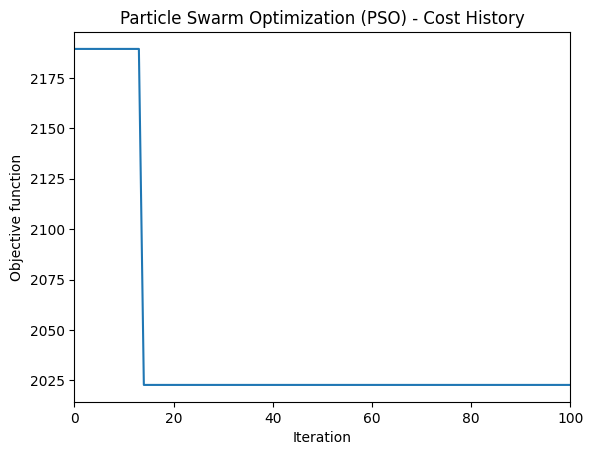

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: inf


In [326]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

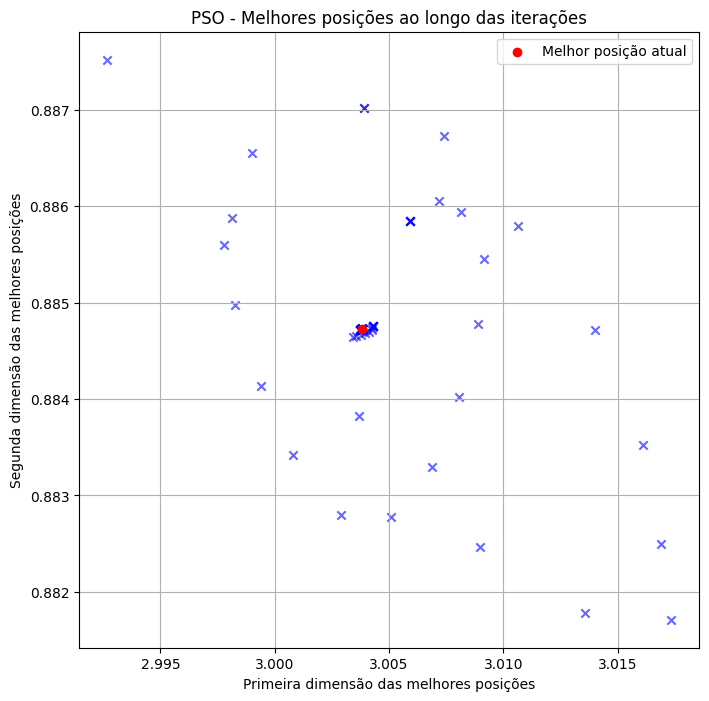

In [327]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()